# Image Compression for Stylized Images - Dimensionality Reduction

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io scikit-image


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
from sklearn.manifold import TSNE


#

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2022-09-05 17:35:19.848394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 17:35:19.848713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 17:35:19.906994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 17:35:19.907219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 17:35:19.907375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


In [5]:
root_dir = "result/stylized_compression"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)


## Load Training Data

#

In [6]:
def load_from_directory(data_dir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize, cache_name="stylizedAECache"):
        #ds = ds.cache(filename='/tmp/{0}'.format(cache_name), name=cache_name)
        #ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float16)
        lab = tfio.experimental.color.rgb_to_lab(image)

        return lab

    nrBatches = len(train_ds)

    # Translate [0,255] -> [-1, 1]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))
    #normalized_expected_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))

    # Combined train and expected data.
    normalized_train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds))

    #normalized_train_ds = configure_for_performance(normalized_train_ds, AUTOTUNE, 0, "stylizedAECacheTrain")

    final_normalized_train_ds = normalized_train_ds.take(int(train_size * nrBatches))

    offset_skip = int(train_size * nrBatches)
    validation_nr_batchs = int((1.0 - train_size) * nrBatches)
    normalized_test_ds = normalized_train_ds.skip(offset_skip).take(validation_nr_batchs)

    return final_normalized_train_ds, normalized_test_ds #configure_for_performance(normalized_test_ds, AUTOTUNE, 0, "stylizedAECacheValidation")


In [7]:


BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (128, 128)
EPOCHS = 12

data_directory_path = "data-stylized-compression/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE, 0.9)

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

print("Validation: Number of batches {0} of {1} elements".format(
    len(validation_images), BATCH_SIZE))


Found 184327 files belonging to 1 classes.
Train: Number of batches 2592 of 64 elements
Validation: Number of batches 288 of 64 elements


## Augment DataSet
By augmenting the image, it can reduce overfitting since no image will be the same between each epoch.

In [8]:
trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    layers.RandomRotation(0.5)
])


def func(x, y):
    aX = trainAug(x)
    return (aX, aX)


trainAugmentedDS = (
    train_images
    .map(func,
         num_parallel_calls=tf.data.AUTOTUNE)
)

trainAugmentedDS = trainAugmentedDS.prefetch(tf.data.AUTOTUNE)
validation_images = validation_images.prefetch(tf.data.AUTOTUNE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
trainAugmentedDS = trainAugmentedDS.with_options(options)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
validation_images = validation_images.with_options(options)



# Example Data

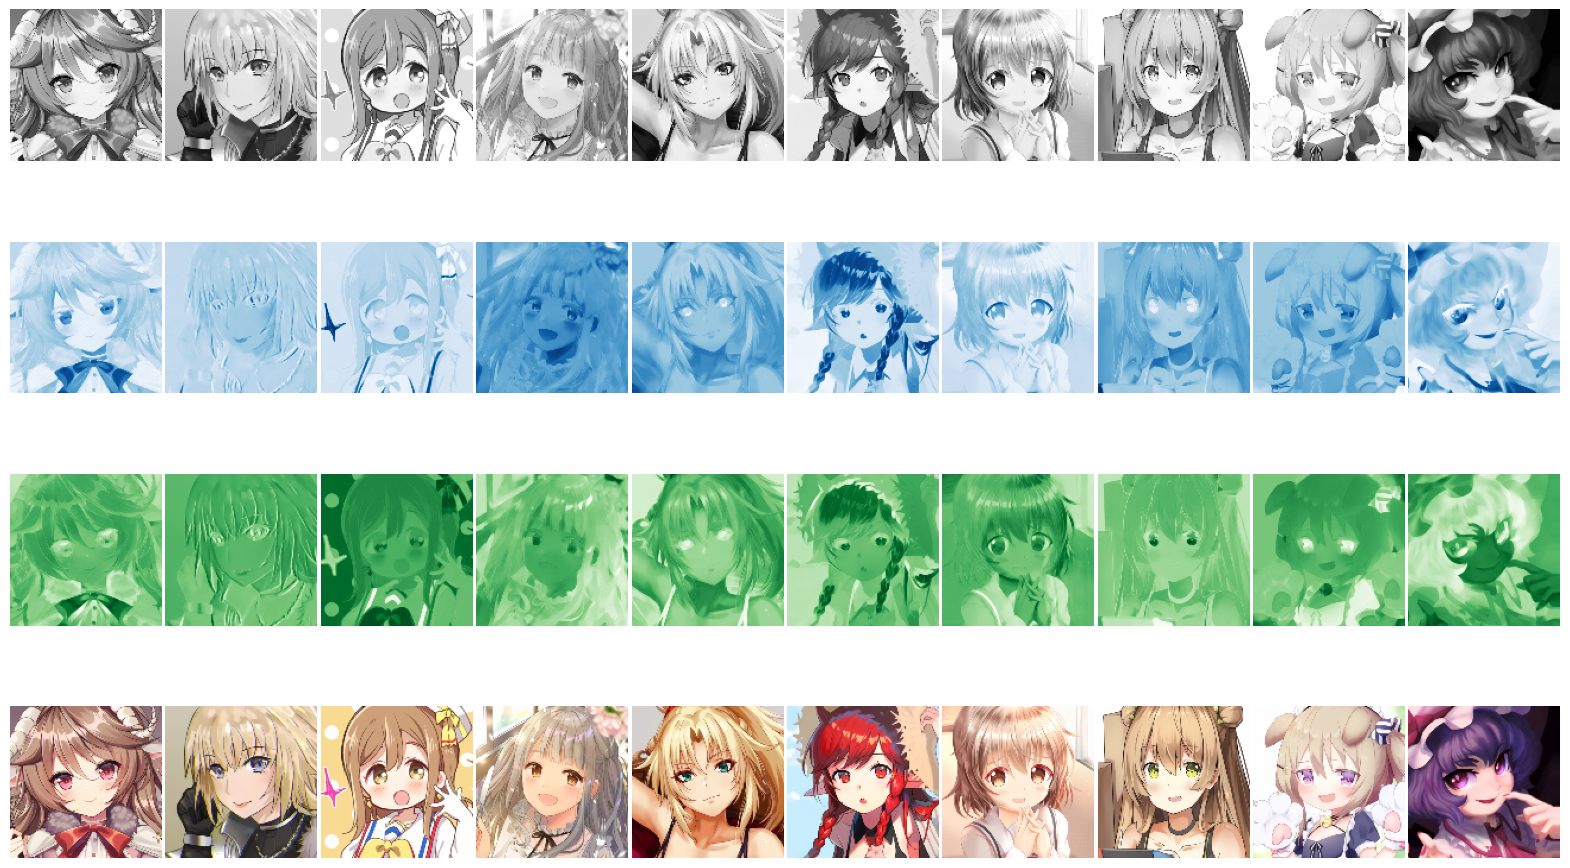

In [9]:
bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)


nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Augmented DataSet
Creates altered image to prevent overfitting

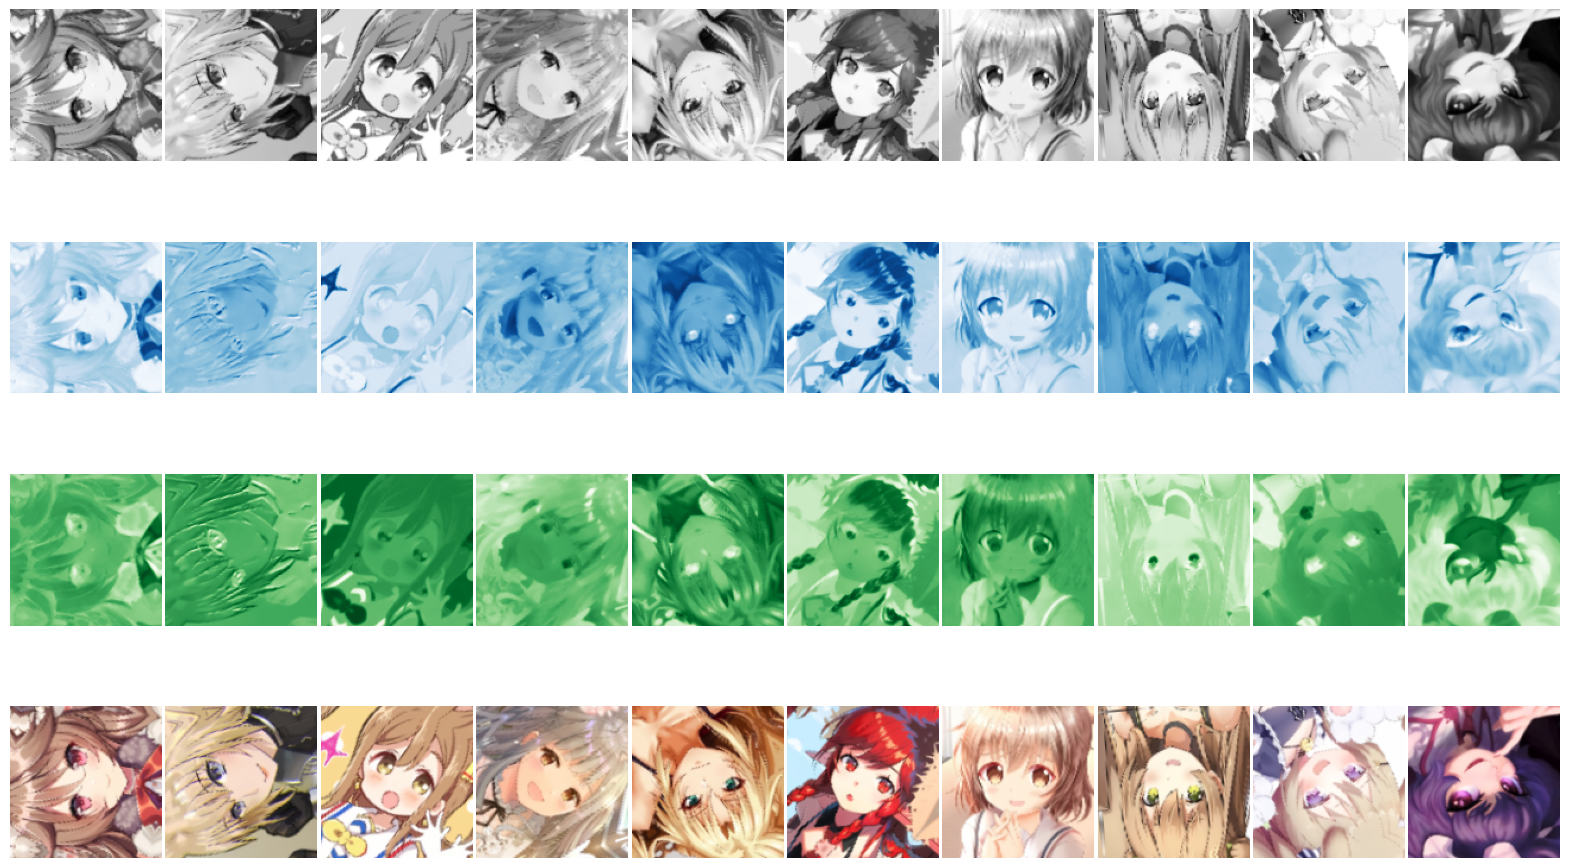

In [10]:
bathc_iter = iter(trainAugmentedDS)
image_batch, expected_batch = next(bathc_iter)

nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


# Create Model

In [11]:
def generate_cnn_builder(hp, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, image_size, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            activation_dict = {
                'leaky_relu': layers.LeakyReLU(alpha=0.2, dtype='float32'),
                'relu': layers.ReLU(dtype='float32')
            }

            batch_norm = hp.Boolean('batch_norm')

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
            kernel_activation = hp.Choice('kernel_activation', ['relu', 'leaky_relu'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=4, max_value=6, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=3, max_value=4, step=1)

            regularization = hp.Int(
                'regularization', min_value=4, max_value=5, step=1)

            encoder_last_conv2 = None

            self.encoder = keras.layers.Input(shape=image_size)

            x = layers.Conv2D(2 ** (hp_kernel_filter_size_l1), (5, 5), strides=1, padding='same', kernel_initializer=kernel_init)(self.encoder)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            x = layers.ReLU(dtype='float32')(x)

            lastSumLayer = x

            for i in range(0, number_layers):
                filter_size = 2 ** (i + hp_kernel_filter_size_l1)

                x = layers.Conv2D(filter_size, (3, 3), strides=1, padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', strides=1, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                AttachLayer = x
                if lastSumLayer is not None:
                    lastSumLayer = layers.Conv2D(filters=filter_size, kernel_size=(1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                    encoder_last_conv2 = lastSumLayer
                    x = layers.add([AttachLayer, lastSumLayer])

                x = layers.ReLU(dtype='float32')(x)
                lastSumLayer = x

            connect_conv_shape = encoder_last_conv2.shape

            # Flatten to connect to forward neuron.
            x = layers.ActivityRegularization(l1=10 ** -regularization)(x)

            self.decoder = layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3]), name='latentspace')(x)
            x = self.decoder

            lastSumLayer = None
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 + number_layers - i)

                #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
                x = layers.UpSampling2D(size=(2, 2))(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                x = layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init)(x)
                if batch_norm:
                    x = layers.BatchNormalization(dtype='float32')(x)
                x = layers.ReLU(dtype='float32')(x)

                AttachLayer = x
                if lastSumLayer is not None:
                    lastSumLayer = layers.Conv2DTranspose(filters=filter_size, kernel_size=(1, 1), kernel_initializer=kernel_init, strides=(2, 2))(lastSumLayer)
                    x = layers.add([AttachLayer, lastSumLayer])
                x = layers.ReLU(dtype='float32')(x)
                lastSumLayer = x

            x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init)(x)
            if batch_norm:
                x = layers.BatchNormalization(dtype='float32')(x)
            self.decoderOutput = layers.Activation(activation='tanh', dtype='float32')(x)

        def compile(self, optimizer, **kwargs):
            super(Autoencoder, self).compile(**kwargs)
            self.optimizer = optimizer

    autoencoder = Autoencoder(hp, image_size)

    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 2e-4, 5e-4])
    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    ae_encoder_input = autoencoder.encoder
    ae_decoder_output = autoencoder.decoderOutput

    conv_autoencoder = keras.Model(inputs=ae_encoder_input, outputs=ae_decoder_output)

    #hp_loss = hp.Choice('loss', ['mse', 'binary_crossentropy'])

    def ssim_loss(y_true, y_pred):
        return 0.5 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))) + tf.keras.losses.mean_squared_error(y_true, y_pred)


    conv_autoencoder.compile(optimizer=optimizer, loss=ssim_loss, metrics=['accuracy'])

    return conv_autoencoder


## Hyperparameter

In [12]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    batch_iter = iter(batchImage)
    image_batch, _ = next(batch_iter)

    fig = plt.figure(figsize=(maxNumImages * 2, 5 * 2))
    for i in range(nrElements):

        ax = plt.subplot(5, maxNumImages, i + 1)
        plt.imshow((asarray(lab2rgb(image_batch[i % len(image_batch)] * 128)).astype(dtype='float32')))
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 1 + i + 1)
        plt.imshow(output[i, :, :, 0], cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 2 + i + 1)
        plt.imshow(output[i, :, :, 1], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 3 + i + 1)
        plt.imshow(output[i, :, :, 2], cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 4 + 1 + i)
        plt.imshow(asarray(lab2rgb(output[i])).astype(dtype='float32'))
        plt.axis("off")

        if len(image_batch) - 1 == i:
            image_batch, _ = next(batch_iter)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, dir_path, latent_space, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData.take(12)
        self.dir_path = dir_path
        self.latent_space = latent_space
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("{0}/StylizedCompression{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))
        fig = showResult(self.model, self.trainSet, 14)
        fig.savefig("{0}/StylizedCompressionBig{1}_{2}.png".format(self.dir_path, self.latent_space, epoch))


In [13]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print('Train Image Size: ' + str(image_shape))


def hyperparamter_model_builder(hp):
    model = generate_cnn_builder(hp, image_shape)
    tf.keras.utils.plot_model(
        model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Cifar100"), show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None
    )
    return model

class SaveTrailImageResultCallback(tf.keras.callbacks.Callback):

    def __init__(self, tuner, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.tuner = tuner

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        state = self.tuner.get_state()
        fig = showResult(self.model, trainAugmentedDS.take(2))
        index = 0
        if len(self.tuner.oracle.start_order) > 0:
            index = self.tuner.oracle.start_order[-1]
        fig.savefig(str.format('{0}/ImageAtEpoch{1}.png', self.tuner.get_trial_dir(index), epoch))


tuner = kt.Hyperband(hyperparamter_model_builder,
                     objective=[kt.Objective("val_accuracy", direction="max")],
                     max_epochs=6,
                     distribution_strategy=strategy,
                     factor=4,
                     directory=str.format('{0}/cache', root_dir),
                     project_name=str.format('Stylized AutoEncoder - {0}', "Compression"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)

tuner.search(trainAugmentedDS.take(100), epochs=EPOCHS,
             validation_data=trainAugmentedDS.skip(100).take(10),
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN(), SaveTrailImageResultCallback(tuner)], verbose=1)

# Get bets models.
best_models = tuner.get_best_models(num_models=8)


Trial 11 Complete [00h 06m 42s]
multi_objective: 0.0

Best multi_objective So Far: 0.0
Total elapsed time: 00h 50m 24s
INFO:tensorflow:Oracle triggered exit


In [14]:
model_results = []
latent_spaces = []

EPOCHS = 18

for ae_model in best_models:

    latent_space = ae_model.get_layer("latentspace").output_shape[1]
    latent_spaces.append(latent_space)

    checkpoint_path = str.format("result/stylized_compression/checkpoints/cp_{0}.ckpt", latent_space)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=0)

    checkpoint = tf.train.Checkpoint(model=ae_model)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

    # The model weights (that are considered the best) are loaded into the model.
    if os.path.exists(checkpoint_path):
        ae_model.load_weights(checkpoint_path)

    autoencoder_history = ae_model.fit(trainAugmentedDS,
                                       epochs=EPOCHS,
                                       shuffle=True, callbacks=[cp_callback, save_images(str.format("result/stylized_compression/stylized_compression_latent_{0}", latent_space), latent_space, train_images)])

    ae_model.save_weights(checkpoint_path)


Epoch 1/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.9536

2022-09-05 18:43:54.608706: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 18:44:07.823034: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1041s 398ms/step - loss: 0.3566 - accuracy: 0.9536
Epoch 2/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9537

2022-09-05 19:02:13.770764: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 19:02:24.955362: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1095s 422ms/step - loss: 0.3564 - accuracy: 0.9537
Epoch 3/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 19:19:58.561553: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 19:20:09.554565: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1070s 412ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 4/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 19:38:06.760479: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 19:38:17.369171: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1082s 416ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 5/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 19:55:52.079545: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 19:56:02.981604: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1066s 410ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 6/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 20:12:45.172820: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 20:12:56.371198: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1012s 390ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 7/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 20:29:59.426576: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 20:30:10.705511: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1035s 398ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 8/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 20:47:01.212404: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 20:47:12.194839: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1021s 393ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 9/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 21:03:52.841782: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 21:04:03.903151: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1011s 389ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 10/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9537

2022-09-05 21:21:16.625416: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 21:21:28.567682: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1044s 402ms/step - loss: 0.3564 - accuracy: 0.9537
Epoch 11/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 21:38:31.870323: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 21:38:43.310220: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1034s 398ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 12/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9536

2022-09-05 21:56:05.959138: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 21:56:17.307597: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1053s 405ms/step - loss: 0.3563 - accuracy: 0.9536
Epoch 13/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 22:13:52.564726: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 22:14:05.097133: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1068s 411ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 14/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 22:31:32.029360: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 22:31:43.154566: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1057s 407ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 15/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9536

2022-09-05 22:48:37.494003: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 22:48:48.153431: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1025s 394ms/step - loss: 0.3564 - accuracy: 0.9536
Epoch 16/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9536

2022-09-05 23:06:55.164834: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 23:07:05.969023: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1097s 422ms/step - loss: 0.3564 - accuracy: 0.9536
Epoch 17/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.9536

2022-09-05 23:24:44.780935: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 23:24:55.743865: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1067s 411ms/step - loss: 0.3564 - accuracy: 0.9536
Epoch 18/18
2592/2592 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9537

2022-09-05 23:42:26.552899: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-05 23:42:37.719807: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1062s 409ms/step - loss: 0.3563 - accuracy: 0.9537
Epoch 1/18
2592/2592 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9324

2022-09-06 00:00:27.415170: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1081s 412ms/step - loss: 0.1811 - accuracy: 0.9324
Epoch 2/18
2592/2592 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9667

2022-09-06 00:17:19.547571: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1011s 389ms/step - loss: 0.1007 - accuracy: 0.9667
Epoch 3/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704

2022-09-06 00:34:26.417792: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1029s 396ms/step - loss: 0.0762 - accuracy: 0.9704
Epoch 4/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9713

2022-09-06 00:52:01.380670: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 00:52:12.495780: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1053s 405ms/step - loss: 0.0634 - accuracy: 0.9713
Epoch 5/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9717

2022-09-06 01:09:13.859883: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1032s 397ms/step - loss: 0.0555 - accuracy: 0.9717
Epoch 6/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9723

2022-09-06 01:26:29.728772: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 01:26:40.450969: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1036s 398ms/step - loss: 0.0494 - accuracy: 0.9723
Epoch 7/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9722

2022-09-06 01:43:36.174401: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1026s 395ms/step - loss: 0.0460 - accuracy: 0.9722
Epoch 8/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9725

2022-09-06 02:00:27.495501: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 02:00:38.447015: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1011s 389ms/step - loss: 0.0426 - accuracy: 0.9725
Epoch 9/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9729

2022-09-06 02:17:57.761195: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1047s 403ms/step - loss: 0.0402 - accuracy: 0.9729
Epoch 10/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9731

2022-09-06 02:35:09.948959: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1032s 397ms/step - loss: 0.0389 - accuracy: 0.9731
Epoch 11/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9710

2022-09-06 02:52:01.091075: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 02:52:12.003205: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1013s 390ms/step - loss: 0.0489 - accuracy: 0.9710
Epoch 12/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9719

2022-09-06 03:09:24.035238: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-p

2592/2592 [==============================] - 1040s 400ms/step - loss: 0.0413 - accuracy: 0.9719
Epoch 13/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9731

2022-09-06 03:26:29.149044: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 03:26:40.294117: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1027s 395ms/step - loss: 0.0385 - accuracy: 0.9731
Epoch 14/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9738

2022-09-06 03:43:42.621133: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 03:43:53.717453: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1031s 397ms/step - loss: 0.0373 - accuracy: 0.9738
Epoch 15/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9738

2022-09-06 04:00:37.095808: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 04:00:48.127341: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1014s 390ms/step - loss: 0.0364 - accuracy: 0.9738
Epoch 16/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9741

2022-09-06 04:18:23.744890: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 04:18:37.564919: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1069s 411ms/step - loss: 0.0344 - accuracy: 0.9741
Epoch 17/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9740

2022-09-06 04:36:04.764458: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 04:36:15.852149: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1058s 407ms/step - loss: 0.0340 - accuracy: 0.9740
Epoch 18/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9743

2022-09-06 04:53:46.564640: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 04:53:57.224374: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1061s 409ms/step - loss: 0.0327 - accuracy: 0.9743
Epoch 1/18
2592/2592 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9347

2022-09-06 05:15:10.055431: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 05:15:22.306343: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1284s 489ms/step - loss: 0.2369 - accuracy: 0.9347
Epoch 2/18
2592/2592 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9644

2022-09-06 05:36:49.828870: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 05:37:00.597795: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1298s 500ms/step - loss: 0.1535 - accuracy: 0.9644
Epoch 3/18
2592/2592 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9674

2022-09-06 05:59:01.026429: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 05:59:12.836927: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1333s 513ms/step - loss: 0.1233 - accuracy: 0.9674
Epoch 4/18
2592/2592 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9690

2022-09-06 06:21:27.475967: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 06:21:38.290598: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1344s 517ms/step - loss: 0.1049 - accuracy: 0.9690
Epoch 5/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9701

2022-09-06 06:43:22.984030: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 06:43:34.263481: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1316s 507ms/step - loss: 0.0929 - accuracy: 0.9701
Epoch 6/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9705

2022-09-06 07:05:25.566302: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 07:05:36.686749: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1328s 511ms/step - loss: 0.0852 - accuracy: 0.9705
Epoch 7/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9709

2022-09-06 07:28:07.276309: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 07:28:18.021029: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1355s 522ms/step - loss: 0.0795 - accuracy: 0.9709
Epoch 8/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9714

2022-09-06 07:49:24.975281: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 07:49:35.617010: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1277s 492ms/step - loss: 0.0748 - accuracy: 0.9714
Epoch 9/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9720

2022-09-06 08:11:50.230454: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 08:12:01.559599: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1345s 518ms/step - loss: 0.0705 - accuracy: 0.9720
Epoch 10/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9721

2022-09-06 08:34:18.297136: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 08:34:29.326416: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1348s 519ms/step - loss: 0.0677 - accuracy: 0.9721
Epoch 11/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9727

2022-09-06 08:56:49.712473: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 08:57:00.633498: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1350s 520ms/step - loss: 0.0644 - accuracy: 0.9727
Epoch 12/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9731

2022-09-06 09:18:01.070326: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 09:18:12.228154: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1271s 489ms/step - loss: 0.0619 - accuracy: 0.9731
Epoch 13/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9732

2022-09-06 09:40:19.993745: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 09:40:31.235789: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1340s 516ms/step - loss: 0.0603 - accuracy: 0.9732
Epoch 14/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9736

2022-09-06 10:02:31.428671: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 10:02:42.489296: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1330s 512ms/step - loss: 0.0583 - accuracy: 0.9736
Epoch 15/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9737

2022-09-06 10:25:04.917972: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 10:25:16.078855: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1353s 521ms/step - loss: 0.0569 - accuracy: 0.9737
Epoch 16/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9736

2022-09-06 10:47:38.527947: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 10:47:49.615731: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1353s 521ms/step - loss: 0.0556 - accuracy: 0.9736
Epoch 17/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9741

2022-09-06 11:09:55.320222: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 11:10:06.966410: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1343s 517ms/step - loss: 0.0539 - accuracy: 0.9741
Epoch 18/18
2592/2592 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9742

2022-09-06 11:31:59.413985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 184327
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-09-06 11:32:10.552244: W tensorflow/core/grappler/optimizers/data/au

2592/2592 [==============================] - 1317s 507ms/step - loss: 0.0528 - accuracy: 0.9742
Epoch 1/18
  13/2592 [..............................] - ETA: 20:35 - loss: 0.3363 - accuracy: 0.8869

## Saving Model

In [ ]:
for ae_model in best_models:
    ae_model.save("result/stylized_compression/stylized-ae-compression.h5")

    ae_model.layers[1].save("result/stylized_compression/stylized-encoder.h5")
    ae_model.layers[2].save("result/stylized_compression/stylized-decoder.h5")
    encoder = ae_model.layers[1]
    decoder = ae_model.layers[2]


## Result
The result is both in how good the model reconstruct as well how much of a compression ratio it would yield.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]
    print("Latent Space ", latent_space_size)

    result = ae_model.evaluate(validation_images, batch_size=BATCH_SIZE, verbose=0)
    print("loss, accuracy ", result)


Latent Space  16


2022-08-05 01:29:47.916093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-05 01:44:08.686523: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


loss, accuracy  [0.02514222264289856, 0.9385086297988892]
Latent Space  16
loss, accuracy  [0.042462099343538284, 0.9161767363548279]
Latent Space  16
loss, accuracy  [0.3058066666126251, 0.9384972453117371]
Latent Space  4096
loss, accuracy  [0.20533522963523865, 0.9396572113037109]
Latent Space  16
loss, accuracy  [0.3735292851924896, 0.9385086297988892]
Latent Space  4096
loss, accuracy  [0.017375117167830467, 0.9477706551551819]


In [ ]:

def plotCostHistories(results, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure(figsize=(len(results) * 6.25, 10), dpi=300)
    for i, (latent_space, result) in enumerate(zip(latent_spaces, results)):
        ax = plt.subplot(1, len(results), i + 1)
        for k, v in result.history.items():
            plt.plot(v, label=k)
        ax.title.set_text(str.format('Latent Space {0}', latent_space))

        plt.ylabel(ylabel=y_label)
        plt.xlabel(xlabel=x_label)
        plt.legend(loc="upper left")
    plt.show(block=False)
    plt.savefig(title + ".png")


plotCostHistories(model_results, title=str.format(
    "Stylized Compression Performance History"))


<Figure size 0x3000 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
for ae_model in best_models:
    showResult(ae_model, train_images, 8)


## Plot Dimensional Reduction

In [ ]:
# Plot Result
fig = plt.figure(figsize=(len(best_models) * 10, 2 * 5), dpi=300)
for i, (lantent_space, model) in enumerate(zip(latent_spaces, best_models)):
    ax = plt.subplot(1, len(best_models), i + 1)
    encoder_model = model.layers[1]
    latent_value = encoder_model.predict(train_images, batch_size=256, verbose=0)

    if len(latent_value[0]) > 1:
        tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate='auto')
        X_tsne = tsne.fit_transform(latent_value)
        ax.title.set_text(str.format('Latent Space {0}', lantent_space))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        plt.colorbar()
    else:
        plt.scatter(latent_value[:, 0], np.zeros(len(latent_value)))
        plt.colorbar()
plt.show(block=False)


## Compression Ratio
Since the purpose of dimmension reduction is for creating a lossy compression that hopefully has a lower size than either the jpg/png. In respect to the level lossy.

In [ ]:
# Compute evolution
for ae_model in best_models:
    latent_space_size = ae_model.layers[1].output_shape[1]

    raw_image_size_byte = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    latent_space_byte = latent_space_size * 4
    compression_ratio = float(raw_image_size_byte) / float(latent_space_byte)

    # Compute error.
    print("Compression Ratio", compression_ratio)


Compression Ratio 1.5


In [ ]:
for ae_model in best_models:
    validation_latent_spaces = []
    for batch in validation_images:
        train, expected = batch
        encoder_model = model.layers[1]
        latent_space = encoder_model.predict(train, verbose=0)
        validation_latent_spaces.append(latent_space)

    compressed_file_path = 'result/stylized_compression/latent_space.npy'
    validation_latent_spaces = np.asarray(validation_latent_spaces).flatten()
    np.save(compressed_file_path, validation_latent_spaces)

    raw_latent_space_size_byte = len(validation_latent_spaces) * 4
    compressed_latent_space_size_byte = os.path.getsize(compressed_file_path)
    compression_ratio = float(raw_latent_space_size_byte) / float(compressed_latent_space_size_byte)
    print("Raw Latent space", raw_latent_space_size_byte)
    print("Compressed Latent space", compressed_latent_space_size_byte)
    print("Compression Ratio", compression_ratio)


Raw Latent space 21756903424
Compressed Latent space 10878451840
Compression Ratio 1.9999999764672396


## Episode Improvement Transition

In [ ]:
anim_file = 'result/stylized_compression/stylized-compression.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('StylizedCompression*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


## Present LatentSpace

In [ ]:
import scipy
import moviepy.editor


In [ ]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [ ]:
def generate_transition(model, latent_space, grid_size):
    nr_elemenets = 4
    seeds = np.random.randint(10000, size=2)
    zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
          for s in seeds]

    all_latents = interpolate(zs, nr_elemenets)

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(grid_size[0] * 2, grid_size[1] * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(grid_size[0], grid_size[1], i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()


In [ ]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


In [ ]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 16

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    # Generate figure in respect new latent pace
    fig = generate_grid_image(autoencoder_model.layers[2], latents, (5, 5), (4, 4))

    # Convert figure to bitmap.
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('result/stylized_compression/autoencoder_stylized_compression_transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file autoencoder_stylized_compression_transition_grid_1802.gif with imageio.


In [ ]:
Image(url=gif_filepath)


In [ ]:
# Transition between two sets of images.


In [ ]:
for ae_model in best_models:
    ae_model.summary()
    ae_model.layers[1].summary()
    ae_model.layers[2].summary()
